In [36]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

PermissionError: [Errno 1] Operation not permitted

# MANGA Dataset
---

### Preprocessing

In [ ]:
# Training and Validation data
transforms = v2.Compose([
    v2.Resize((256, 256)), # Resize to 224x224
    v2.ToTensor(),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # Normalize
])

# Create Datasets for Training and Validation
PATH = './animeface-character-dataset/animeface-character-dataset' 
train_dataset = ImageFolder(PATH, transform=transforms)

In [17]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9754
    Root location: ./animeface-character-dataset/animeface-character-dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [18]:
# Create a DataLoader for batching and shuffling the data
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Generator
---

In [34]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_size, maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.ReLU(True),
            # state size. (maps*8) x 4 x 4
            nn.ConvTranspose2d(maps * 8, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.ReLU(True),
            # state size. (maps*4) x 8 x 8
            nn.ConvTranspose2d(maps * 4, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.ReLU(True),
            # state size. (maps*2) x 16 x 16
            nn.ConvTranspose2d(maps * 2, maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps),
            nn.ReLU(True),
            # state size. (maps) x 32 x 32
            nn.ConvTranspose2d(maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


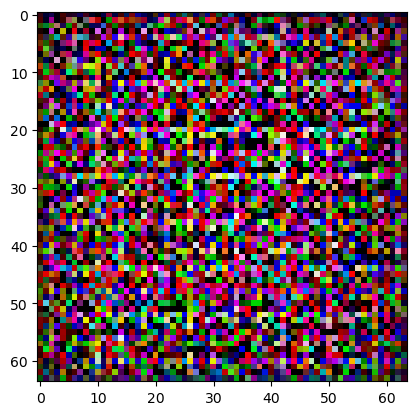

In [35]:
generator = Generator()
noise = torch.randn(64, 128, 1, 1)
output = generator(noise)
plt.imshow(output[0].detach().numpy().transpose(1, 2, 0))
plt.show()

# Discriminator
---